In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Fn 1: Root Mean Squared Percentage Error Function

According to Kaggle, submissions are evaluated on the Root Mean Square Percentage Error (RMSPE). The RMSPE is calculated as such:

$$RMSPE = \sqrt{\frac{1}{n}\sum_{i=1}^n\left(\frac{y_i - \hat{y}_i}{y_i}\right)^{2}}$$

The code below is a function that calculates the RMSPE.

In [2]:
# Function that calculates and returns the RMSPE
def rmspe(y_test, y_pred):
    
    y_test=np.array(y_test)
    y_pred=np.array(y_pred)

    ytest_ypred = pd.DataFrame(y_test, y_pred).reset_index()
    ytest_ypred.columns = ['Predicted_Sales','Actual_Sales']

    # Removing rows that contain zero to prevent division by zero when calculating RMSPE
    ytest_ypred.drop(ytest_ypred[ytest_ypred['Actual_Sales']==0].index,axis=0, inplace=True)

    rmspe = np.sqrt(np.mean(((ytest_ypred['Actual_Sales']-ytest_ypred['Predicted_Sales']) / ytest_ypred['Actual_Sales']) ** 2))
    return rmspe

# Fn 2: Residuals Plotting Function

The code below is a function that plots the residuals against time. Residuals are defined as the difference between the actual sales values and the predicted sales values.

Residual plots are a way to visualize how the errors are distributed. Ideally, the errors should be distributed randomly with a mean of zero, and the standard deviation of the errors should not change with time.

In [3]:
# Function that plots residuals against time for train_validation dataset
def residual_plot(y_pred, train_sub_val_file_path, model_type):
    
    train_sub_validation = pd.read_csv(train_sub_val_file_path, index_col = 0, dtype=types)
    train_sub_validation['Date'] = pd.to_datetime(train_sub_validation['Date'])
    
    plotting_df = pd.DataFrame()
    plotting_df[['Date','Sales']] = train_sub_validation[['Date', 'Sales']]
    plotting_df['Predicted_Sales'] = np.array(y_pred)

    plotting_df['Residuals'] = plotting_df['Sales'] - plotting_df['Predicted_Sales']
    
    # Calculating the mean
    residual_mean = plotting_df['Residuals'].mean()
    
    # Calculating the standard deviations
    residual_std = plotting_df['Residuals'].std()
    
    # Plotting the residuals
    fig, ax = plt.subplots(figsize = (16,8))
    ax.scatter(plotting_df['Date'].values, plotting_df['Residuals'].values, marker='+', alpha = 0.5)
    ax.set_xlabel('Time')
    ax.set_ylabel('Sales residuals')
    ax.set_title('Scatterplot of {} residuals against time'.format(model_type))
    
    # Plotting the mean of residuals as a horizontal line
    ax.axhline(y=residual_mean, color='black')
    ax.text('2015-06-08', residual_mean, 'mean={:.1f}'.format(residual_mean), fontsize=10, backgroundcolor='w')
    
    # Plotting the first standard deviations as horizontal lines
    ax.axhline(y=residual_mean+residual_std, color='black', linestyle = ':')
    ax.axhline(y=residual_mean-residual_std, color='black', linestyle = ':')
    ax.text('2015-08-05', residual_mean+residual_std, '+1 standard deviation', fontsize=10, backgroundcolor='w')
    ax.text('2015-08-05', residual_mean-residual_std, '-1 standard deviation', fontsize=10, backgroundcolor='w')
    
    return ax

# Fn 3: Residual mean and standard deviation function

The code below is a function that calculates and returns the mean and standard deviations of the residuals

In [4]:
def residual_mean_std(y_pred, train_sub_val_file_path):
    
    train_sub_validation = pd.read_csv(train_sub_val_file_path, index_col = 0, dtype=types)
    train_sub_validation['Date'] = pd.to_datetime(train_sub_validation['Date'])
    
    df = pd.DataFrame()
    df[['Date','Sales']] = train_sub_validation[['Date', 'Sales']]
    df['Predicted_Sales'] = np.array(y_pred)
    df['Residuals'] = df['Sales'] - df['Predicted_Sales']
    
    # Calculating the mean
    residual_mean = df['Residuals'].mean()
    
    # Calculating the standard deviations
    residual_std = df['Residuals'].std()
    
    return(residual_mean, residual_std)

# Fn 4: Actual sales vs Predicted sales plot function

The code below is a function that plots out the time series plots of actual sales and predicted sales of selected stores in the train_validation dataset.

In [5]:
# Plotting the actual sales and predicted sales of the train_validation dataframe for selected stores
def actual_pred_sales_plot(y_pred, train_sub_val_file_path):

    # Import train_validation.csv into a dataframe
    train_sub_validation = pd.read_csv(train_sub_val_file_path, index_col = 0, dtype=types)
    train_sub_validation['Date'] = pd.to_datetime(train_sub_validation['Date'])
    
    # Incorporate y_pred into train_validation dataframe
    train_sub_validation['Predicted_Sales'] = y_pred
    
    selected_stores = [2, 7, 85, 259, 562, 1, 4, 732, 530, 512]

    for store_id in selected_stores:
        fig, ax = plt.subplots(figsize = (16,3))
        ax.plot(train_sub_validation[train_sub_validation['Store']==store_id]['Date'], train_sub_validation[train_sub_validation['Store']==store_id]['Sales'])
        ax.plot(train_sub_validation[train_sub_validation['Store']==store_id]['Date'], train_sub_validation[train_sub_validation['Store']==store_id]['Predicted_Sales'])
        ax.set_title('Plot of actual sales and predicted sales against time for Store {}'.format(store_id))
        ax.set_ylabel('Sales')
        plt.legend()
        plt.show()

    return ax

# Fn 5: Random Forest Hyperparameter Tuning Function

The code below is a function that tries out different value of n_estimators in our Random Forest model.

**n_estimators - the number of decision trees used in the Random Forest model.**

The reason for creating our own Hyperparameter tuning function instead of using Scikit-Learn's GridSearchCV function is because GridSearchCV does k-folds cross-validation on our dataset. We cannot perform this action on a time series, since this would mean we are using data in the future to validate data in the past. We are only allowed to use data in the past to validate data in the future.

In [6]:
def RF_Hyperparameter_Tuning(X_train_sub, y_train_sub, X_train_sub_validation, y_train_sub_validation):
    
    from sklearn.ensemble import RandomForestRegressor

    # Dictionary that holds the values of n_estimators we want to try out
    hyperparameter_dict={'n_estimators':[25,50,100,150,200,250]}

    # Dictionary that holds the values of n_estimators and the corresponding rmspe score for each n_estimator
    hyperparameter_rmspe = {'n_estimators': [],'rmspe':[]}

    i = 0

    while i < 6:
        for key, value in hyperparameter_dict.items():
            hyperparameter_rmspe[key].append(value[i])

            print('Hyperparameters used:')
            print('n_estimators: {}'.format(hyperparameter_rmspe['n_estimators'][i]),'\n')

        # Instantiate our RandomForestRegressor
        rf = RandomForestRegressor(n_estimators=hyperparameter_rmspe['n_estimators'][i],random_state=1,n_jobs=-1,verbose=1)

        # Training our RandomForestRegressor model
        rf.fit(X_train_sub, y_train_sub)

        # Predicting the test set labels
        y_pred = rf.predict(X_train_sub_validation)

        # Calculate the RMSPE of our Random Forest
        print('The rmspe of our Random Forest model is:',rmspe(y_train_sub_validation, y_pred))

        # Demarcating the end of the printouts of one loop from the next loop
        print('\n')
        print('-'*50)

        # Append the calculated rmspe to hyperparameter_rmspe
        hyperparameter_rmspe['rmspe'].append(rmspe(y_train_sub_validation, y_pred))

        i = i+1

    # Convert hyperparameter_rmspe from dictionary to DataFrame for easy viewing
    hyperparameter_rmspe_df = pd.DataFrame.from_dict(hyperparameter_rmspe)

    return hyperparameter_rmspe_df

# Random Forest Model #1

We will be using the Random Forest algorithm to train our model.

The advantages of using the Random Forest model are:
1. Being a tree-based model, it can describe non-linear dependencies between features and the target.
2. There is less preprocessing work required to be performed on the features - no need to perform one-hot encoding, and no need to standardize the features.

The second point has the greater impact on the choice of using a tree-based model for our dataset. This is because we are predicting the sales for 1,115 stores. Performing one-hot encoding on the stores would produce well over 1,000 features, and this would make our preprocessing work more difficult and the model fitting time longer.

In Random Forest Model #1, we will use the following features to predict sales:
1. Store (the store number)
2. DayOfWeek
3. Open
4. Promo
5. Mean_Sales_DoW
6. SchoolHoliday
7. StateHoliday
7. Year
8. Month
9. Week

We will need to create features for **Mean_Sales_DoW**, **Year**, **Month**, and **Week**.

## 1. Feature Engineering on train_sub

In [7]:
# Import the train_sub dataset
types = {'StateHoliday': np.dtype(str)}
train_sub = pd.read_csv('train_sub.csv', dtype=types, parse_dates=[3]).iloc[:,1:]

# Create the features Year, Month and Week
train_sub['Year'] = train_sub.Date.dt.year
train_sub['Month'] = train_sub.Date.dt.month
train_sub['Week'] = train_sub.Date.dt.week

# Encode the elements in 'StateHoliday' column with numbers
mapper_stateholiday ={'a':1,'b':2,'c':3}
train_sub['StateHoliday'] = train_sub['StateHoliday'].replace(mapper_stateholiday)
train_sub['StateHoliday'] = train_sub['StateHoliday'].astype(np.int64)

# Create the feature Mean_Sales_DoW
# Grouping by Store and DayOfWeek, calculate the mean sales
mean_sales_dow = train_sub.groupby(['Store','DayOfWeek'])['Sales'].mean()
mean_sales_dow = mean_sales_dow.reset_index()

# Append the mean_sales_dow to the train_sub_validation dataset
train_sub1 = pd.merge(train_sub, mean_sales_dow, how='left', on=['Store','DayOfWeek'])
train_sub1.rename(columns={'Sales_x':'Sales', 'Sales_y': 'Mean_Sales_DoW'}, inplace=True)

# Choose only the features we will use for our Random Forest Model #1
RFModel1_features = ['Store','DayOfWeek','Open','Promo','SchoolHoliday','StateHoliday','Year','Month','Week','Mean_Sales_DoW']
train_sub_RFModel1 = train_sub1[RFModel1_features]

train_sub_RFModel1.head()

,Store,DayOfWeek,Open,Promo,SchoolHoliday,StateHoliday,Year,Month,Week,Mean_Sales_DoW
0,1,5,1,1,0,0,2015,6,25,4527.945736
1,2,5,1,1,0,0,2015,6,25,4455.550388
2,3,5,1,1,0,0,2015,6,25,6821.472868
3,4,5,1,1,0,0,2015,6,25,8995.720930
4,5,5,1,1,0,0,2015,6,25,4622.581395


In [8]:
# Create the target variable for train_sub
y_train_sub = train_sub['Sales'].values

In [9]:
train_sub_RFModel1.dtypes

Store               int64
DayOfWeek           int64
Open                int64
Promo               int64
SchoolHoliday       int64
StateHoliday        int64
Year                int64
Month               int64
Week                int64
Mean_Sales_DoW    float64
dtype: object

## 2. Feature Engineering on train_sub_validation

In [10]:
# Import the train_sub_validation dataset
types = {'StateHoliday': np.dtype(str)}
train_sub_validation = pd.read_csv('train_sub_validation.csv', dtype=types, parse_dates=[3]).iloc[:,1:]

# Create the features Year, Month and Week
train_sub_validation['Year'] = train_sub_validation.Date.dt.year
train_sub_validation['Month'] = train_sub_validation.Date.dt.month
train_sub_validation['Week'] = train_sub_validation.Date.dt.week

# Encode the elements in 'StateHoliday' column with numbers
mapper_stateholiday ={'a':1,'b':2,'c':3}
train_sub_validation['StateHoliday'] = train_sub_validation['StateHoliday'].replace(mapper_stateholiday)
train_sub_validation['StateHoliday'] = train_sub_validation['StateHoliday'].astype(np.int64)

# Create the feature Mean_Sales_DoW
# Append the mean_sales_dow to the train_sub_validation dataset
train_sub_validation1 = pd.merge(train_sub_validation, mean_sales_dow, how='left', on=['Store','DayOfWeek'])
train_sub_validation1.rename(columns={'Sales_x':'Sales', 'Sales_y': 'Mean_Sales_DoW'}, inplace=True)

# Choose only the features we will use for our Random Forest Model #1
train_sub_validation_RFModel1 = train_sub_validation1[RFModel1_features]

train_sub_validation_RFModel1.head()

,Store,DayOfWeek,Open,Promo,SchoolHoliday,StateHoliday,Year,Month,Week,Mean_Sales_DoW
0,1,5,1,1,1,0,2015,7,31,4527.945736
1,2,5,1,1,1,0,2015,7,31,4455.550388
2,3,5,1,1,1,0,2015,7,31,6821.472868
3,4,5,1,1,1,0,2015,7,31,8995.720930
4,5,5,1,1,1,0,2015,7,31,4622.581395


In [11]:
# Create the target variable for train_sub_validation
y_train_sub_validation = train_sub_validation['Sales'].values

## 3. Feature Engineering on test data set

In [12]:
# Import test.csv into a dataframe
types = {'StateHoliday': np.dtype(str)}
test = pd.read_csv('test.csv', dtype=types).iloc[:,2:]
test['Date'] = pd.to_datetime(test['Date'])

# Create the features Year and Month
test['Year'] = test.Date.dt.year
test['Month'] = test.Date.dt.month
test['Week'] = test.Date.dt.week

# Encode the elements in 'StateHoliday' column with numbers
mapper_stateholiday ={'a':1,'b':2,'c':3}
test['StateHoliday'] = test['StateHoliday'].replace(mapper_stateholiday)
test['StateHoliday'] = test['StateHoliday'].astype(np.int64)

# Create the feature Mean_Sales_DoW
# Append the mean_sales_dow to the test dataset
test1 = pd.merge(test, mean_sales_dow, how='left', on=['Store','DayOfWeek'])
test1.rename(columns={'Sales': 'Mean_Sales_DoW'}, inplace=True)

# Choose only the features we will use for our Random Forest Model #1
test_RFModel1 = test1[RFModel1_features]

test_RFModel1.head()

,Store,DayOfWeek,Open,Promo,SchoolHoliday,StateHoliday,Year,Month,Week,Mean_Sales_DoW
0,1,4,1.0,1,0,0,2015,9,38,4081.922481
1,3,4,1.0,1,0,0,2015,9,38,6338.790698
2,7,4,1.0,1,0,0,2015,9,38,7981.891473
3,8,4,1.0,1,0,0,2015,9,38,5912.480620
4,9,4,1.0,1,0,0,2015,9,38,5556.937984


## 4. Hyperparameter tuning of Random Forest Model #1

In [13]:
RF_Hyperparameter_Tuning(train_sub_RFModel1, y_train_sub, train_sub_validation_RFModel1, y_train_sub_validation)

Hyperparameters used:
n_estimators: 25 



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   25.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.0s finished


The rmspe of our Random Forest model is: 0.13940357993568425


--------------------------------------------------
Hyperparameters used:
n_estimators: 50 



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   47.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished


The rmspe of our Random Forest model is: 0.13858607674932547


--------------------------------------------------
Hyperparameters used:
n_estimators: 100 



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.9s finished


The rmspe of our Random Forest model is: 0.1380166005470107


--------------------------------------------------
Hyperparameters used:
n_estimators: 150 



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.5s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    7.9s finished


The rmspe of our Random Forest model is: 0.13786759212063815


--------------------------------------------------
Hyperparameters used:
n_estimators: 200 



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  3.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   17.2s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:   17.2s finished


The rmspe of our Random Forest model is: 0.13789157448402956


--------------------------------------------------
Hyperparameters used:
n_estimators: 250 



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  4.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   21.9s
[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:   25.3s finished


The rmspe of our Random Forest model is: 0.13788189701886427


--------------------------------------------------


,n_estimators,rmspe
0,25,0.139404
1,50,0.138586
2,100,0.138017
3,150,0.137868
4,200,0.137892
5,250,0.137882


## 5. Training Random Forest Model #1

Since we don't see huge gains by using 250 trees compared to 150 trees, we shall use 150 trees for our training.

In [14]:
from sklearn.ensemble import RandomForestRegressor

# Instantiate our RandomForestRegressor
rf_m1 = RandomForestRegressor(n_estimators=150,random_state=1,n_jobs=-1,verbose=1)

# Training our RandomForestRegressor model
rf_m1.fit(train_sub_RFModel1, y_train_sub)

# Predicting the test set labels
y_pred = rf_m1.predict(train_sub_validation_RFModel1)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.5s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    7.4s finished


## 6. Scoring Decision Tree Model #1 on train_sub_validation data set

In [15]:
# Calculate the RMSPE of our Random Forest
rmspe(y_train_sub_validation, y_pred)

0.13786759212063815

## 7. Plot the residuals

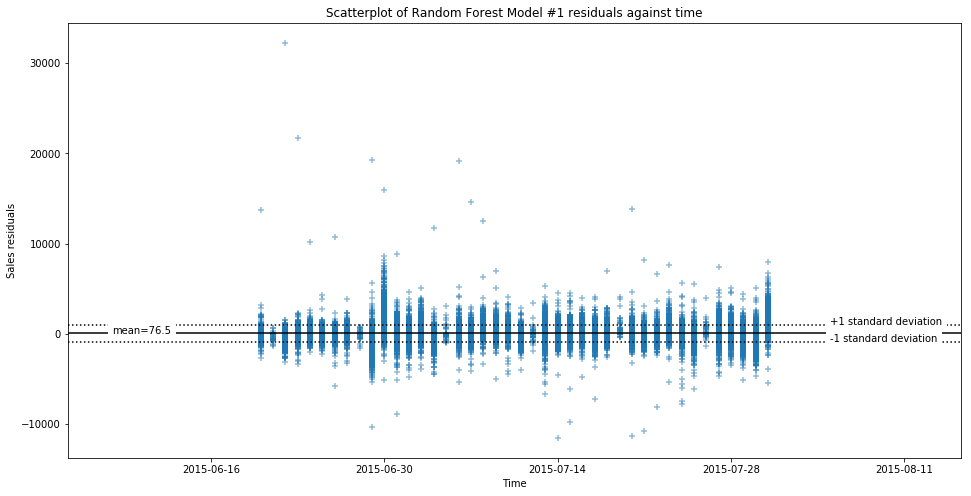

In [16]:
# Plot the residuals
residual_plot(y_pred, 'train_sub_validation.csv','Random Forest Model #1')
plt.show()

## 8. Calculate the mean and standard deviation of the residuals

In [17]:
# Mean of Decision Tree model #1 residuals
print('The mean of the residuals of RF Model #1 is {:.3f}'.format(residual_mean_std(y_pred, 'train_sub_validation.csv')[0]))

# Standard deviation of Decision Tree model #1 residuals
print('The standard deviation of the residuals of RF Model #1 is {:.3f}'.format(residual_mean_std(y_pred, 'train_sub_validation.csv')[1]))

The mean of the residuals of RF Model #1 is 76.532
The standard deviation of the residuals of RF Model #1 is 944.300


## 9. Plot Actual Sales and Predicted Sales against time

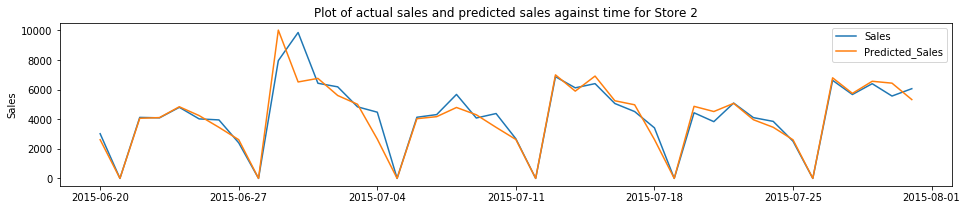

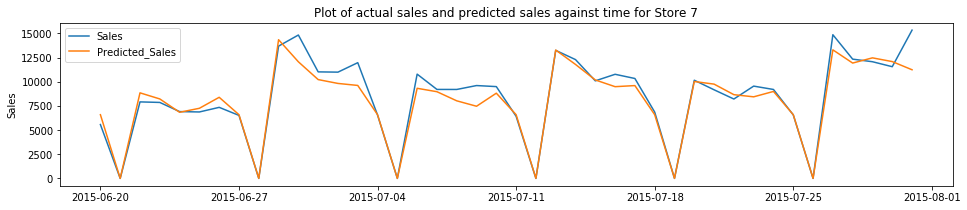

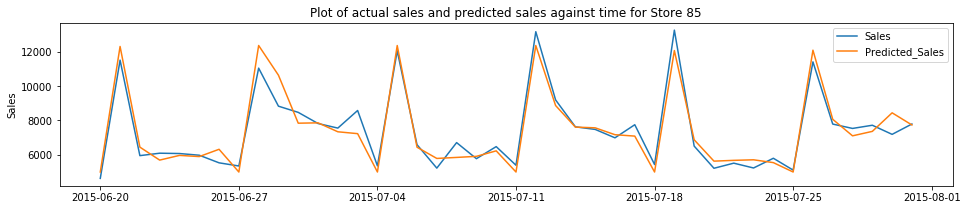

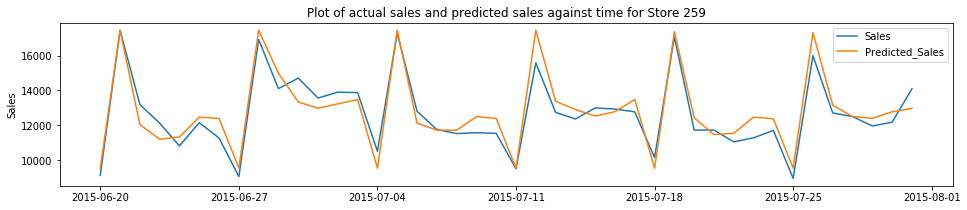

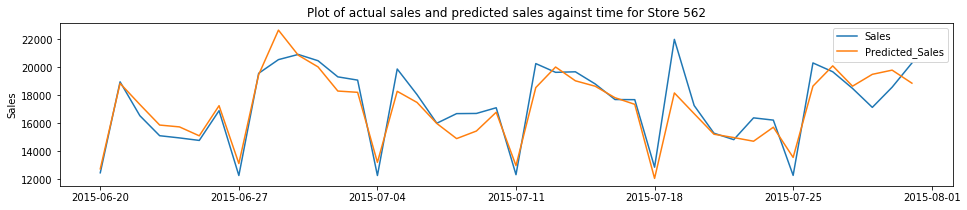

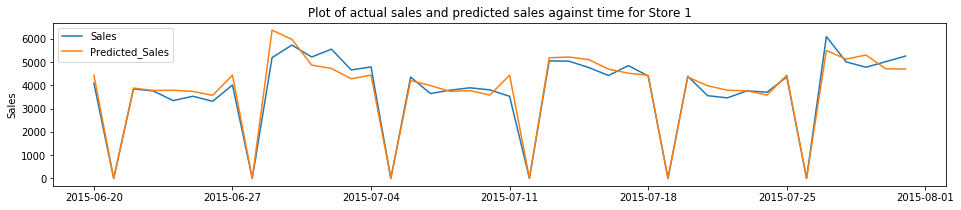

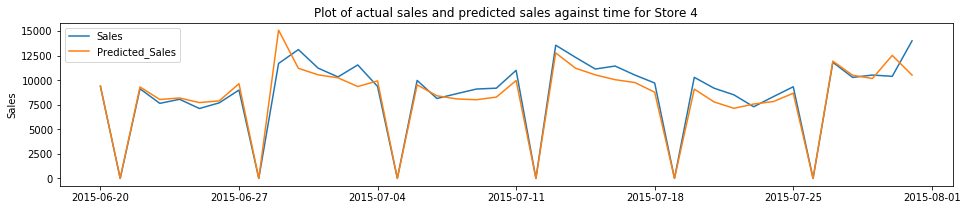

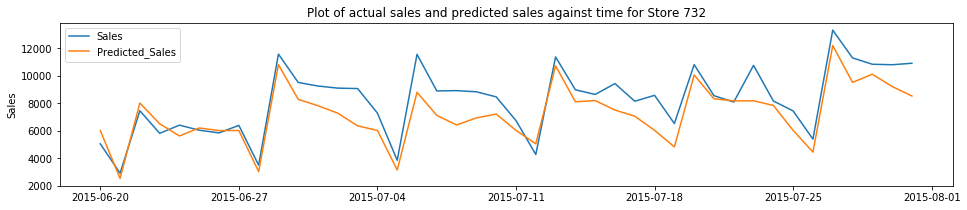

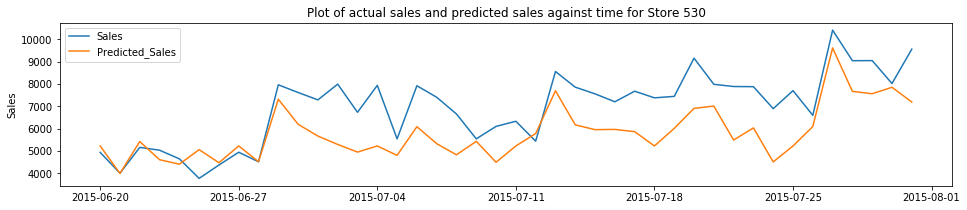

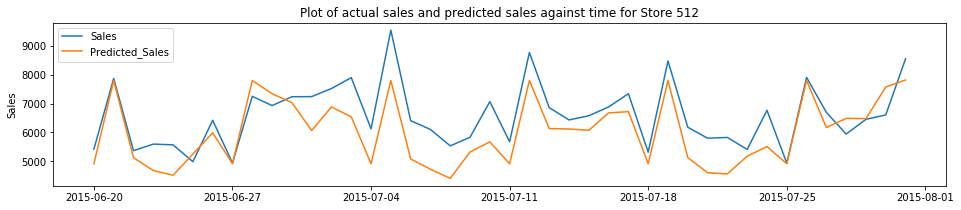

In [18]:
actual_pred_sales_plot(y_pred, 'train_sub_validation.csv')
plt.show()

## 10. Random Forest Model #1 - Feature Importances

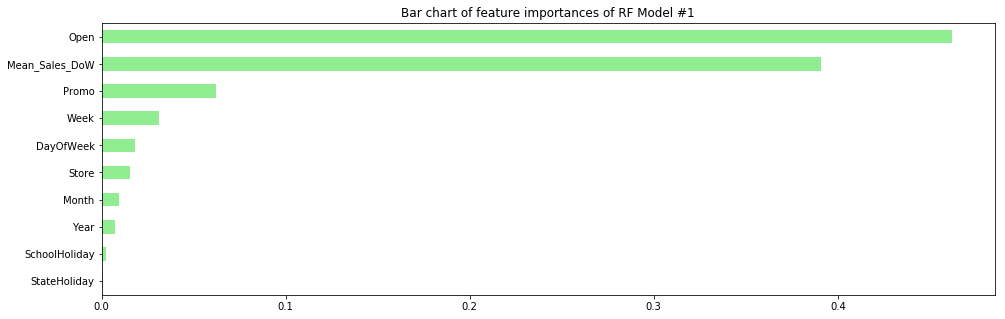

In [19]:
# Extract the feature importances
importance_rf_m1 = pd.Series(rf_m1.feature_importances_, index=train_sub_RFModel1.columns)
sorted_importance_rf_m1 = importance_rf_m1.sort_values()

# Plot the sorted importances
fig, ax = plt.subplots(figsize=(16,5))
sorted_importance_rf_m1.plot(kind='barh', color='lightgreen', ax=ax)
ax.set_title('Bar chart of feature importances of RF Model #1')
plt.show()

## 11. Evaluation of Random Forest Model #1 on test set

We will be generating sales predictions for the test set, and upload the results to Kaggle to see what score will be achieved.

In [20]:
# Generating the predictions for test set
y_pred_test = rf_m1.predict(test_RFModel1)

# Import the test dataset
types = {'StateHoliday': np.dtype(str)}
test = pd.read_csv('test.csv', dtype=types).iloc[:,1:]

# Append the predicted sales to the test dataset
test['Sales'] = y_pred_test

# Remove unnecessary columns and save the result in csv format
rf_model_1 = test[['Id','Sales']]
rf_model_1.set_index('Id', inplace=True)
rf_model_1.to_csv('rf_model_1.csv')

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    2.3s finished


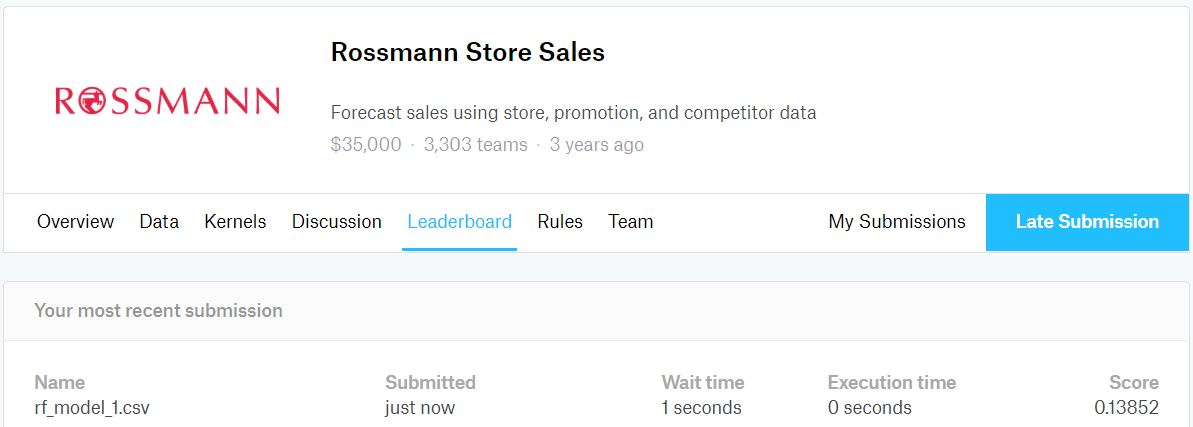

The rmspe score by Kaggle of Random Forest model 1 is 0.13852, which is much better than the rmspe score of 0.18447 achieved by Baseline Model 2.